In [1]:
import sklearn
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
import pandas as pd
from sklearn import preprocessing
import random
from sklearn.ensemble import RandomForestRegressor
import cvxpy as cp
import matplotlib.pyplot as plt
### install gurobi
from gurobipy import *
import multiprocessing as mp
import time
import gurobipy as gp
from gurobipy import GRB


import sklearn
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
import pandas as pd
from sklearn import preprocessing
import random
from sklearn.ensemble import RandomForestRegressor
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import multiprocessing as mp
import time

import interpret
import mosek
from interpret import *

In [7]:
from interpret.glassbox import ExplainableBoostingRegressor

In [3]:
dataset = sklearn.datasets.fetch_california_housing()
X, y = dataset.data, dataset.target  # pylint: disable=no-member
X = pd.DataFrame(X,columns = dataset.feature_names)

X['y'] = y
y = X['y']
X.drop('y', axis = 1, inplace = True)

features = dataset.feature_names
#X =  preprocessing.scale(X)
#y =  preprocessing.scale(y)
X = pd.DataFrame(X,columns = features)
xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)

In [12]:
# Diamonds Dataset
dataset =  pd.read_csv('diamonds.csv')
dataset = dataset.sample(1000)
dataset.drop('Unnamed: 0',axis = 1,inplace = True)
y = dataset['price']
X = dataset.drop('price',axis = 1)
X = pd.get_dummies(X)
features = X.columns
X = preprocessing.scale(X)
y =  preprocessing.scale(y)
X = pd.DataFrame(X,columns = features)

In [2]:
dataset = load_boston()
X, y = dataset.data, dataset.target  # pylint: disable=no-member
X = pd.DataFrame(X,columns = dataset.feature_names)
features = dataset.feature_names
for col in random.sample(list(X.columns),3):
    new_col = col +'corr'
    X[new_col] = X[col] + np.random.normal(0,np.std(X[col]),len(X))
    features = np.append(features,new_col)
X = preprocessing.scale(X)
y =  preprocessing.scale(y)
X = pd.DataFrame(X,columns = features)


In [3]:
def boosted_sparse_rf(arg):
    
    xTrain = arg[0]
    yTrain = arg[1]
    
    xTest= arg[2]
    yTest= arg[3]
    num_trees= arg[4]
    colsample_by_tree= arg[5]
    max_depth= arg[6]
    lambd= arg[7]
    threshold= arg[8]
    use_indicators= arg[9]
    col_subsample_split= arg[10]
    n_estimators= arg[11]
    
    
    train = xTrain.copy()
    train['yTrain'] = yTrain
    feature_list = xTrain.columns
    nfeatures = len(feature_list)

    importance_key = pd.DataFrame(feature_list,columns = ['Features'])

    t_start = time.time()
### Build Trees
    tree_results = []
    i = 0
    to_sample = round(colsample_by_tree*nfeatures)
    while i < num_trees:
      #train each tree on bootstrapped data
        train1 = train.sample(n = len(train), replace = True)
        features = random.sample(list(feature_list),to_sample)
        
        yTrain1 = train1['yTrain']
        xTrain1 = train1[features]
        gbt = GradientBoostingRegressor(learning_rate = 1.0,max_depth = max_depth,n_estimators = n_estimators).fit(xTrain1,yTrain1)
        
        for clf1 in gbt.estimators_:
            clf = clf1[0]
            imp = pd.DataFrame(np.column_stack((xTrain1.columns,clf.feature_importances_)), columns = ['Features','Importances'])
            used = imp[imp['Importances']>0]['Features'].values
            feature_indicator = [int(x in used) for x in feature_list]
            pred = clf.predict(xTrain[features])
            feature_importances = pd.merge(importance_key,imp, on = 'Features', how = 'left').fillna(0)['Importances'].values
            test_pred = clf.predict(xTest[features])
            tree_results.append([pred,feature_indicator,feature_importances, test_pred  ,clf,xTrain1,yTrain1,features])
            
        i = i+1
    t_trees = time.time()
    print('tree building time: ' ,t_trees-t_start)
    
    
### Lasso Step To Select Features
    tree_pred = np.transpose(np.array([np.array(row[0]) for row in tree_results]))
    test_pred = np.transpose(np.array([np.array(row[3]) for row in tree_results]))
    indicators = np.transpose(np.array([np.array(row[1]) for row in tree_results]))
    
    w = cp.Variable(num_trees*n_estimators,nonneg=True)

    
    if use_indicators == True:
        objective = 0.5 * (1/len(yTrain))*cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) + lambd*cp.norm(cp.matmul(indicators,w),1)
    if use_indicators == False:
        objective = 0.5  * (1/len(yTrain))* cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) + lambd*cp.norm(w,1)

    prob = cp.Problem(cp.Minimize(objective) )
    prob.solve(solver = cp.MOSEK )
    weights = np.asarray(w.value)
    low_values_flags = np.abs(weights) < threshold  # Where values are low
    weights[low_values_flags] = 0 

### Refit Least Squares to get Weights

    tree_ind = np.where(weights >0)[0]
    
    tree_ind = np.where(weights >0)[0]
    if len(tree_ind)==0:
        train_error =  np.sqrt(np.mean((yTrain )**2))
        test_error = np.sqrt(np.mean((yTest )**2))
        return([[],test_error,0,train_error])
    
    
    tree_pred_non_zero = np.array([np.array(row[tree_ind]) for row in tree_pred])
    test_pred_non_zero = np.array([np.array(row[tree_ind]) for row in test_pred])

    final_tree_weights = cp.Variable(len(tree_ind), nonneg = True)
    objective_final = cp.sum_squares(cp.matmul(tree_pred_non_zero,final_tree_weights)-yTrain) 

    prob = cp.Problem(cp.Minimize(objective_final))
    prob.solve(solver = cp.MOSEK)
    
    t_solve = time.time()
    print('time optimization: ' ,t_solve - t_trees)
    
### Return Train/Test Predictions 
    final_train_pred = tree_pred_non_zero@final_tree_weights.value
    final_test_pred = test_pred_non_zero@final_tree_weights.value

### Return Feature Importances
    importances = np.array([np.array(row[2]) for row in tree_results])
    feature_importances = pd.DataFrame(np.column_stack((feature_list, np.transpose(importances[tree_ind])@np.abs(final_tree_weights.value))),columns = ['Features','Importances']).sort_values('Importances',ascending = False)
    feature_importances['Importances'] = feature_importances['Importances']/sum(feature_importances['Importances'])
    nonzero_features = sum(feature_importances['Importances']!= 0)
### Return Accuracies
    train_error =  np.sqrt(np.mean((yTrain -final_train_pred)**2))
    test_error = np.sqrt(np.mean((yTest -final_test_pred)**2))

    return([feature_importances,test_error,nonzero_features,train_error])


def sparse_rf(arg):
    
    xTrain = arg[0]
    yTrain = arg[1]
    xTest= arg[2]
    yTest= arg[3]
    num_trees= arg[4]
    colsample_by_tree= arg[5]
    max_depth= arg[6]
    lambd= arg[7]
    threshold= arg[8] 
    use_indicators= arg[9]
    col_subsample_split= arg[10]
    
    
    train = xTrain.copy()
    train['yTrain'] = yTrain
    feature_list = xTrain.columns
    nfeatures = len(feature_list)

    importance_key = pd.DataFrame(feature_list,columns = ['Features'])

### Build Trees
    tree_results = []
    i = 0
    to_sample = round(colsample_by_tree*nfeatures)
    print(to_sample)
    while i < num_trees:
      #train each tree on bootstrapped data
        train1 = train.sample(n = len(train), replace = True)
        features = random.sample(list(feature_list),to_sample)
        
        yTrain1 = train1['yTrain']
        xTrain1 = train1[features]
        
        clf = DecisionTreeRegressor(max_depth = max_depth,max_features = col_subsample_split).fit(xTrain1,yTrain1)
        imp = pd.DataFrame(np.column_stack((xTrain1.columns,clf.feature_importances_)), columns = ['Features','Importances'])
        used = imp[imp['Importances']>0]['Features'].values
        feature_indicator = [int(x in used) for x in feature_list]
        pred = clf.predict(xTrain[features])
        feature_importances = pd.merge(importance_key,imp, on = 'Features', how = 'left').fillna(0)['Importances'].values
        test_pred = clf.predict(xTest[features])
        tree_results.append([pred,feature_indicator,feature_importances, test_pred  ,clf,xTrain1,yTrain1,features])
        i = i+1

### Lasso Step To Select Features
    tree_pred = np.transpose(np.array([np.array(row[0]) for row in tree_results]))
    test_pred = np.transpose(np.array([np.array(row[3]) for row in tree_results]))
    indicators = np.transpose(np.array([np.array(row[1]) for row in tree_results]))
    w = cp.Variable(num_trees,nonneg=True)
  

    if use_indicators == True:
        objective = 0.5 * (1/len(yTrain))*cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) + lambd*cp.norm(cp.matmul(indicators,w),1)
    if use_indicators == False:
        objective = 0.5  * (1/len(yTrain))* cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) + lambd*cp.norm(w,1)

    prob = cp.Problem(cp.Minimize(objective) )
    prob.solve(solver = cp.MOSEK )
    weights = np.asarray(w.value)
    low_values_flags = np.abs(weights) < threshold  # Where values are low
    weights[low_values_flags] = 0 

### Refit Least Squares to get Weights

    tree_ind = np.where(weights >0)[0]
    if len(tree_ind)==0:
        train_error =  np.sqrt(np.mean((yTrain )**2))
        test_error = np.sqrt(np.mean((yTest )**2))
        return([[],test_error,0,train_error])
    
    
    tree_pred_non_zero = np.array([np.array(row[tree_ind]) for row in tree_pred])
    test_pred_non_zero = np.array([np.array(row[tree_ind]) for row in test_pred])

    final_tree_weights = cp.Variable(len(tree_ind), nonneg = True)

    objective_final = cp.sum_squares(cp.matmul(tree_pred_non_zero,final_tree_weights)-yTrain) 

    prob = cp.Problem(cp.Minimize(objective_final))
    prob.solve(solver = cp.MOSEK)

### Return Train/Test Predictions 
    final_train_pred = tree_pred_non_zero@final_tree_weights.value
    final_test_pred = test_pred_non_zero@final_tree_weights.value

### Return Feature Importances
    importances = np.array([np.array(row[2]) for row in tree_results])
    feature_importances = pd.DataFrame(np.column_stack((feature_list, np.transpose(importances[tree_ind])@np.abs(final_tree_weights.value))),columns = ['Features','Importances']).sort_values('Importances',ascending = False)
    feature_importances['Importances'] = feature_importances['Importances']/sum(feature_importances['Importances'])
    nonzero_features = sum(feature_importances['Importances']!= 0)
### Return Accuracies
    train_error =  np.sqrt(np.mean((yTrain -final_train_pred)**2))
    test_error = np.sqrt(np.mean((yTest -final_test_pred)**2))

    return([feature_importances,test_error,nonzero_features,train_error])

In [4]:
### run experiment
pool = mp.Pool(3)
num_trees = 400
colsample_by_tree = 1
max_depth = 4
col_subsample_split = 'auto'
use_indicators = True
threshold = 10**-3
ntrials = 40
n_estimators = 3
lambdrange = np.arange(0,.25,.01)
boost_acc1 = []
boost_nonzero1 = []
boost_train_error = []

bag_acc1 = []
bag_nonzero1 = []
bag_train_error = []


for lambd in lambdrange :
    print(lambd)
    trial = 0
    result1= []
    args = []
    
    
    while trial < ntrials:
        xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)
        args.append([xTrain,yTrain,xTest,yTest,num_trees,colsample_by_tree,max_depth,lambd,threshold, use_indicators,col_subsample_split,n_estimators])
        trial = trial + 1

    result1 = pool.map(boosted_sparse_rf, args)
    acc = [row[1] for row in result1]
    nonzero = [row[2] for row in result1]
    train_acc = [row[3] for row in result1]
    
    boost_acc1.append(acc)
    boost_nonzero1.append(nonzero)
    boost_train_error.append(train_acc)
    
    gc.collect()
    
    while trial < ntrials:
        xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)
        args.append([xTrain,yTrain,xTest,yTest,num_trees*n_estimators,colsample_by_tree,max_depth,lambd,threshold, use_indicators,col_subsample_split])
        trial = trial + 1

    result1 = pool.map(sparse_rf, args)
    acc = [row[1] for row in result1]
    nonzero = [row[2] for row in result1]
    train_acc = [row[3] for row in result1]
    
    
    bag_acc1.append(acc)
    bag_nonzero1.append(nonzero)
    bag_train_error.append(train_acc)
    
    
    
pool.close()

0.0
tree building time:  27.61836004257202
tree building time:  27.744537115097046
tree building time:  28.14770007133484
time optimization:  4.110368013381958
time optimization:  4.133250951766968
time optimization:  3.862781047821045
tree building time:  25.440744876861572
tree building time:  25.83858895301819
tree building time:  25.736445903778076
time optimization:  4.516003847122192
time optimization:  4.48127293586731
time optimization:  4.430978059768677
tree building time:  23.436295747756958
tree building time:  23.368048906326294
tree building time:  23.631919145584106
time optimization:  4.4965009689331055
time optimization:  4.44561505317688
time optimization:  4.482402086257935
tree building time:  23.78541374206543
tree building time:  24.210061073303223
tree building time:  24.672815084457397
time optimization:  5.688565969467163
time optimization:  5.477031946182251
time optimization:  4.902177810668945
tree building time:  24.754430055618286
tree building time:  24.7

tree building time:  23.79308795928955
tree building time:  23.898151874542236
time optimization:  3.4351370334625244
time optimization:  3.3129069805145264
time optimization:  3.431891918182373
tree building time:  23.941597938537598
tree building time:  23.759690046310425
tree building time:  24.045225381851196
time optimization:  3.4504549503326416
time optimization:  3.512861967086792
time optimization:  3.431067705154419
tree building time:  23.79546809196472
tree building time:  23.835134983062744
tree building time:  23.576431035995483
time optimization:  3.5674357414245605
time optimization:  3.6421167850494385
time optimization:  3.5578339099884033
tree building time:  23.66932487487793
tree building time:  23.95070719718933
tree building time:  23.90078377723694
time optimization:  3.2613003253936768
time optimization:  3.4120779037475586
time optimization:  3.4969921112060547
tree building time:  23.898878812789917
tree building time:  23.798042058944702
tree building time: 

time optimization:  2.5985257625579834
time optimization:  2.7466776371002197
time optimization:  2.8030457496643066
tree building time:  17.28218698501587
tree building time:  17.08232092857361
tree building time:  17.256730794906616
time optimization:  2.5360801219940186
time optimization:  2.627599000930786
time optimization:  2.7655751705169678
tree building time:  17.09459090232849
tree building time:  17.006617784500122
tree building time:  17.295819997787476
time optimization:  2.500333070755005
time optimization:  2.5594522953033447
time optimization:  2.6740360260009766
tree building time:  17.297914266586304
tree building time:  16.9820339679718
tree building time:  17.11204981803894
time optimization:  2.5886526107788086
time optimization:  2.6571879386901855
time optimization:  2.604034185409546
tree building time:  17.158362865447998
tree building time:  17.145341873168945
tree building time:  17.113445281982422
time optimization:  2.598604202270508
time optimization:  2.6

time optimization:  4.009690999984741
time optimization:  4.116549968719482
tree building time:  28.466365814208984
tree building time:  28.777990102767944
tree building time:  28.883518934249878
time optimization:  4.670608997344971
time optimization:  4.545849800109863
time optimization:  4.566426992416382
tree building time:  23.24778914451599
tree building time:  23.497225046157837
tree building time:  22.960447072982788
time optimization:  2.8468410968780518
time optimization:  2.924794912338257
time optimization:  2.9540469646453857
tree building time:  25.4162380695343
tree building time:  25.995380878448486
tree building time:  26.261582851409912
time optimization:  4.220570802688599
time optimization:  4.300202131271362
time optimization:  4.175878047943115
tree building time:  26.41781187057495
tree building time:  26.04236102104187
tree building time:  26.51422119140625
time optimization:  3.7846739292144775
time optimization:  3.8305578231811523
time optimization:  3.594980

tree building time:  20.259923934936523
tree building time:  19.96323823928833
tree building time:  20.300339937210083
time optimization:  2.923039197921753
time optimization:  3.0371367931365967
time optimization:  3.024470090866089
tree building time:  19.973220109939575
tree building time:  19.897050142288208
tree building time:  20.222712755203247
time optimization:  2.8417367935180664
time optimization:  2.950169086456299
time optimization:  3.042999029159546
tree building time:  24.331885814666748
tree building time:  24.695362091064453
tree building time:  24.694091081619263
time optimization:  4.227550268173218
time optimization:  4.082211017608643
time optimization:  4.107515811920166
tree building time:  24.060812950134277
tree building time:  24.01858901977539
tree building time:  24.015777111053467
time optimization:  2.9192140102386475
time optimization:  2.950843095779419
time optimization:  3.025723934173584
tree building time:  21.354926824569702
tree building time:  21

tree building time:  41.063353300094604
tree building time:  41.58545398712158
time optimization:  6.483083724975586
time optimization:  7.870725870132446
time optimization:  7.598130941390991
tree building time:  67.95828199386597
tree building time:  67.08506989479065
tree building time:  67.86911678314209
time optimization:  9.03125810623169
time optimization:  8.165651082992554
time optimization:  8.8020601272583
tree building time:  95.19566321372986
tree building time:  95.317312002182
tree building time:  94.6806960105896
time optimization:  10.876359939575195
time optimization:  12.21597695350647
time optimization:  12.461312055587769
tree building time:  67.26687979698181
tree building time:  68.37200379371643
tree building time:  66.7390649318695
time optimization:  8.33155107498169
time optimization:  6.438456058502197
time optimization:  6.463353157043457
tree building time:  27.063591957092285
time optimization:  2.81138014793396
tree building time:  22.750438928604126
tim

time optimization:  5.92596697807312
time optimization:  5.822253942489624
tree building time:  38.35041308403015
tree building time:  38.50380277633667tree building time: 
 38.656728982925415
time optimization:  5.559797048568726
time optimization:  5.850967168807983
time optimization:  5.871565103530884
tree building time:  38.73831915855408
tree building time:  38.05130910873413
tree building time:  38.42091679573059
time optimization:  5.584337949752808
time optimization:  5.85422682762146
time optimization:  5.755281925201416
tree building time:  38.65469527244568
tree building time:  38.23557376861572
tree building time:  38.52091097831726
time optimization:  5.650888919830322
time optimization:  5.766462087631226
time optimization:  5.928775072097778
tree building time:  38.30934405326843
tree building time:  38.32943606376648
tree building time:  38.16987919807434
time optimization:  5.538156986236572
time optimization:  5.858736038208008
time optimization:  5.825897932052612
t

tree building time:  23.87719202041626
time optimization:  3.3142499923706055
time optimization:  3.683398723602295
time optimization:  3.648286819458008
tree building time:  25.004841804504395
tree building time:  24.424540996551514
tree building time:  24.802557945251465
time optimization:  3.3363072872161865
time optimization:  3.313513994216919
time optimization:  3.3466780185699463
tree building time:  13.699718952178955
time optimization:  1.9336729049682617
tree building time:  -177.34158372879028
time optimization:  1.9363219738006592
tree building time:  13.345959901809692
time optimization:  1.900813102722168
tree building time:  17.726534843444824
time optimization:  2.7672131061553955
1616

16
16
16
16
1616

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
0.18
tree building time:  25.503488063812256
tree building time:  25.852779865264893
tree building time:  25.995037078857422
time optimization:  3.8709778785705566
tree build

tree building time:  24.41593027114868
tree building time:  24.76140809059143
tree building time:  25.317718029022217
time optimization:  3.429257869720459
time optimization:  3.5111160278320312
tree building time:  26.076697826385498
tree building time:  26.036064863204956
tree building time:  26.029800176620483
time optimization:  3.5320632457733154
tree building time:  25.87661600112915
tree building time:  25.527158737182617
tree building time:  25.63583993911743
tree building time:  25.427321672439575
tree building time:  25.69548201560974
tree building time:  25.23875880241394
time optimization:  3.790086269378662
tree building time:  24.89807105064392
tree building time:  24.968641757965088
tree building time:  25.113160133361816
tree building time:  28.215285778045654
tree building time:  28.223285913467407
tree building time:  28.636937141418457
time optimization:  3.510915994644165
tree building time:  24.90096092224121
tree building time:  25.174143075942993
tree building ti

In [8]:
def sparse_ebm(xTrain,yTrain,xTest,yTest,lambd,threshold):

    all_features = pd.DataFrame(xTrain.columns,columns = ['Features'])
    ebm = ExplainableBoostingRegressor(n_jobs = 3).fit(xTrain,yTrain)
    ebm_local = ebm.explain_local(xTrain, yTrain)
    pred = ebm.predict(xTest)
    
    #print('ebm acc:',np.sqrt(np.mean((yTest -pred)**2)))
    
    local_imp = []
    for i in range(0,len(yTrain)):
        scores = ebm_local._internal_obj.get('specific')[i].get('scores')
        local_imp.append(scores)

    local_imp = np.array(local_imp)

    test_imp = []
    ebm_test = ebm.explain_local(xTest,yTest)
    for i in range(0,len(yTest)):
        scores = ebm_test._internal_obj.get('specific')[i].get('scores')
        test_imp.append(scores)
    test_imp  = np.array(test_imp)


    #print('ebm local acc:',np.sqrt(np.mean((yTest -np.sum(test_imp,axis = 1))**2)))

    w = cp.Variable(len(xTrain.columns),nonneg=True)

    objective = 0.5 * (1/len(yTrain))*cp.sum_squares(cp.matmul(local_imp,w)-yTrain) + \
                                                    lambd*cp.norm(w,1)

    prob = cp.Problem(cp.Minimize(objective))
    prob.solve(solver=cp.GUROBI)
    weights = np.asarray(w.value)
    low_values_flags = np.abs(weights) < threshold  # Where values are low
    weights[low_values_flags] = 0 

    feature_ind = np.where(weights >0)[0]

    if len(feature_ind) == 0:
        train_error =  np.sqrt(np.mean((yTrain)**2))
        test_error = np.sqrt(np.mean((yTest)**2))
        nonzero_features = 0
        feature_importances = all_features
        feature_importances['Importances'] = 0
        return([feature_importances,test_error,nonzero_features,train_error])


    features_sub = xTrain.columns[feature_ind]
    train_pred_non_zero = np.array([np.array(row[feature_ind]) for row in local_imp])
    test_pred_non_zero = np.array([np.array(row[feature_ind]) for row in test_imp])

    final_tree_weights = cp.Variable(len(feature_ind), nonneg = True)
    objective_final = cp.sum_squares(cp.matmul(train_pred_non_zero,final_tree_weights)-yTrain) 

    prob = cp.Problem(cp.Minimize(objective_final))
    prob.solve(solver=cp.MOSEK)

    final_train_pred = train_pred_non_zero@final_tree_weights.value
    final_test_pred = test_pred_non_zero@final_tree_weights.value

    train_error =  np.sqrt(np.mean((yTrain -final_train_pred)**2))
    test_error = np.sqrt(np.mean((yTest -final_test_pred)**2))
    
    #print('after_opt_accuracy:', test_error)

    importances = np.sum(np.abs(test_pred_non_zero),axis = 0)
    feature_importances = pd.DataFrame(np.column_stack((features_sub,importances))\
                                      ,columns = ['Features','Importances'])
    feature_importances = pd.merge(all_features,feature_importances,on = 'Features',how = 'left').fillna(0).\
                            sort_values('Importances',ascending = False)
    nonzero_features = len(feature_ind)

    
    return([feature_importances,test_error,nonzero_features,train_error])


In [ ]:
ebm_test_acc = []
ebm_nonzero = []
ebm_train_acc = []

lambdrange = np.append(np.arange(0,.102,.002),np.arange(.0102,.25,.05))
ntrials = 20
threshold = 10**-3


for lambd in lambdrange :
    
    trial = 0
    result1 = []
    args = []
    
    while trial < ntrials:
        xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)
        results = sparse_ebm(xTrain,yTrain,xTest,yTest,lambd,threshold)
        result1.append(results)
        trial = trial+1
    
    test_acc = [row[1] for row in result1]
    nonzero = [row[2] for row in result1]
    train_acc = [row[3] for row in result1]
    
    
    ebm_test_acc.append(test_acc)
    ebm_nonzero.append(nonzero)
    ebm_train_acc.append(train_acc)
gc.collect()
        

In [10]:
### Linear Regression with Lasso

lr_test_acc = []
lr_nonzero = []
trial = 0
lambdrange = np.arange(0,.6,.005)
ntrials = 100

for lambd in lambdrange:
    trial = 0
    while trial < ntrials:
        xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)
        lasso_mod = sklearn.linear_model.Lasso(alpha = lambd).fit(xTrain,yTrain)
        pred = lasso_mod.predict(xTest)
        test_error = np.sqrt(np.mean((yTest -pred)**2))
        nonzero = len(np.where(lasso_mod.coef_ != 0)[0])
        lr_test_acc.append(test_error)
        lr_nonzero.append(nonzero)
        trial = trial + 1
        
gc.collect()
            

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.811520032816645, tolerance: 0.032268422718186265
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: C

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.86490721532977, tolerance: 0.034862109233212896
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.34191105766392, tolerance: 0.03562994959970265
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipy

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.63156972461263, tolerance: 0.04012218769037893
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWa

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.70742218950966, tolerance: 0.03529636127238454
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coo

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.875336278067365, tolerance: 0.03599109935081621
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceW

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.5299646209492, tolerance: 0.03674326983353731
  positive)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWar

0

In [11]:
gc.collect()

20

In [12]:
def plot_tradeoff_curve(test_acc,nonzero,color,ntrials,label):
    results = pd.DataFrame()
    for i in range(0,len(test_acc)):
        results = results.append(pd.DataFrame(np.column_stack((test_acc[i],nonzero[i])),columns = ['test_acc','nonzero']))
    agg = results.groupby(['nonzero'], as_index=False).agg({'test_acc':['mean','std']})
    #plt.figure(figsize=(16,10))
    plt.plot(agg['nonzero'],agg['test_acc']['mean'],color = color,label = label)
    plt.errorbar(agg['nonzero'],agg['test_acc']['mean'], 1.96*agg['test_acc']['std']/np.sqrt(ntrials),color = color)
    plt.xlabel('Number of Nonzero Features')
    plt.ylabel('Test Error')
    plt.legend()

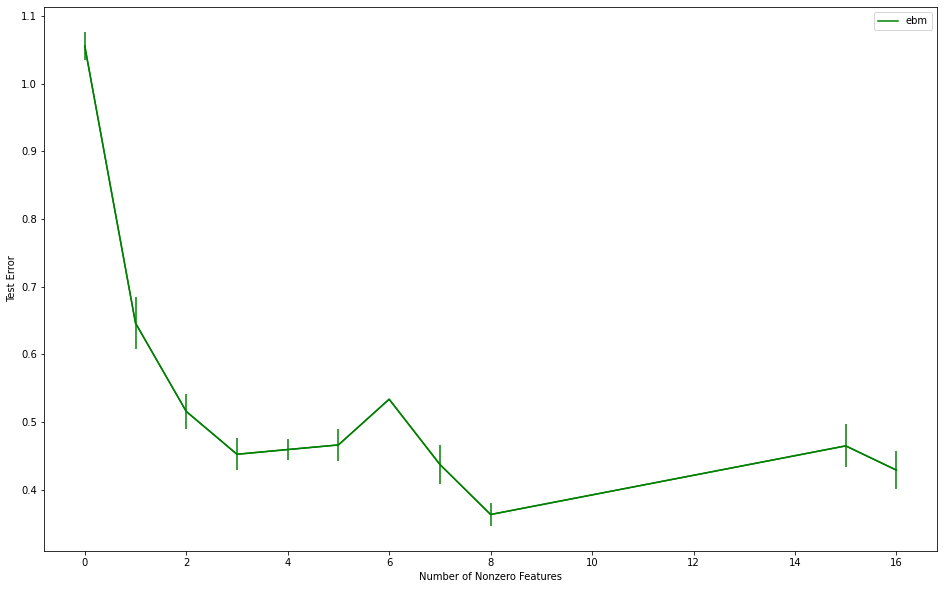

In [16]:
plt.figure(figsize = (16,10))

#plot_tradeoff_curve(boost_acc1,boost_nonzero1,'red',20,'boosting')
#plot_tradeoff_curve(bag_acc1,bag_nonzero1,'orange',20,'bagging')

plot_tradeoff_curve(ebm_test_acc,ebm_nonzero,'green',20,'ebm')
#plot_tradeoff_curve(lr_test_acc,lr_nonzero,'blue',100,'linear regression')